(Shengqi) Since we have many parallel versions, I created this guidebook so any version can get the updates smoothly by following these steps in a few minutes. Hopefully it can also help understand what has been done.

## 0. Preliminary

This walkthrough is based on Keigo's 11/30 version on Github. 

If you are able to run on your local version but the results are largely different, it may be because some local changes have been made and haven't been revoked. No need to worry too much as long as the code is running bug-free on your side, but it is recommended that you try these on that 11/30 version.

If you are unable to get these to run on your local version, please contack me.

This code assumes the issues we mentioned earlier has been resolved. If you're not sure, please check these:


### Under "class GraphClass":
Line 11 of the block

**Previous version:** self.adj_matrix = nx.to_numpy_array(self.graph)

**Make Sure You Have:** self.adj_matrix = nx.to_numpy_array(self.graph, **weight=None**)


### Making sense of baseline models ("class ExperimentClass")
**current version (DeGroot-adapted Das/Abebe):**

new_opinions = self.conformity * **self.opinions** + ... 

**if you want real Das:**

new_opinions = self.conformity * **self.initial_opinions** + ... *(no need to change anything else)*

**This code is based on the current version, denoted as "our DeGroot Das".**

Let me know if the meanings here remain unclear --
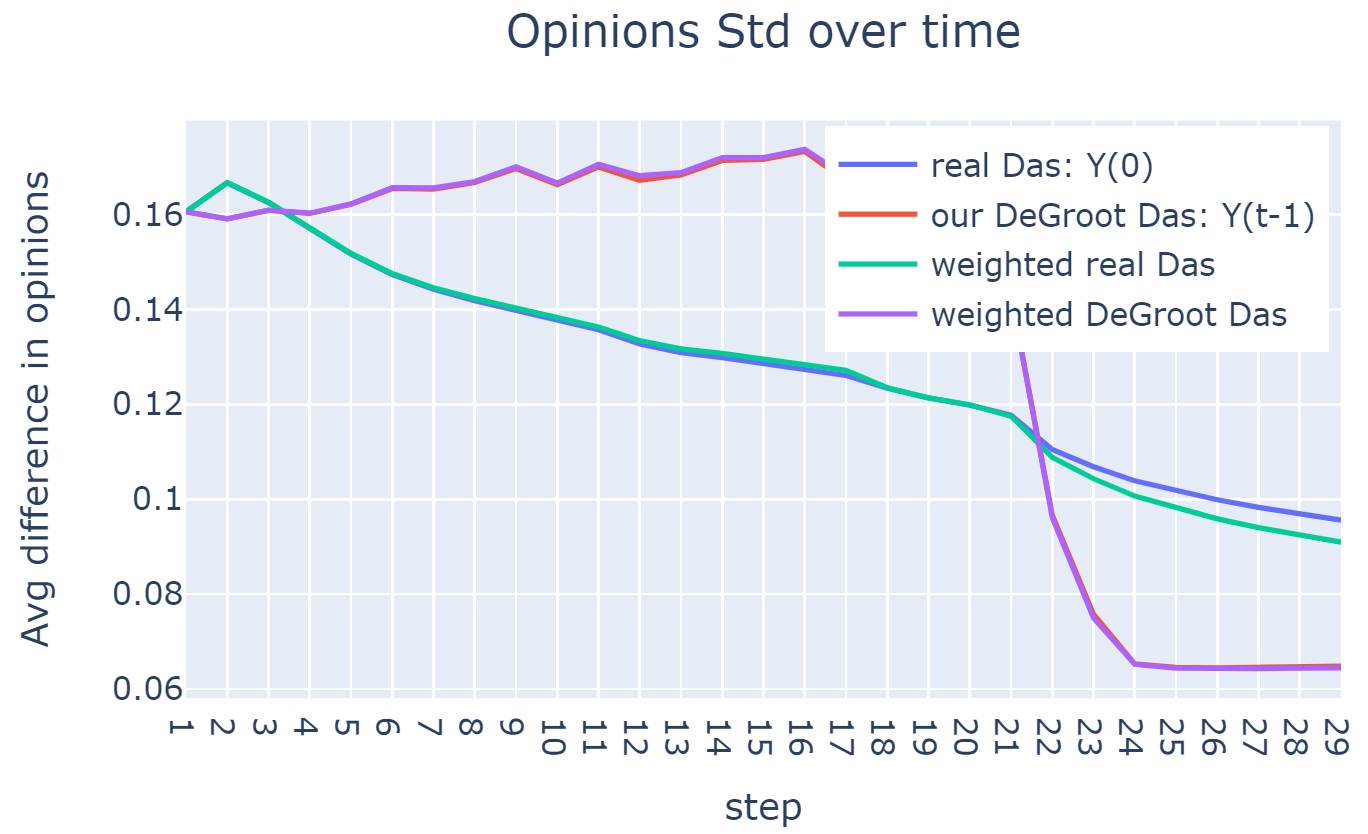

 

## 1. Add Support for Vectorized Opinions



Generally, single-value opinions can be naturally extended to vectors thanks to *broadcasting*, i.e. allowing point-wise to be done between (n, 1) and (n, dim) vectors. Nonetheless there are some details that needs change.

### class GraphClass:
Line 18 ("self.opinions = np.array(..."):

**Delete ".reshape((-1, 1))" at the end**

<br>


### class GraphAttributeClass:
Line 14:

**Previous Version:** self.g.nodes[node]['opinion'] = **0**

**Change to:** self.g.nodes[node]['opinion'] = **None**

<br>

Line 20:

**Previous Version:** if self.g.nodes[init_nbr]['opinion'] **!= 0**:

**Change to:** if self.g.nodes[init_nbr]['opinion'] **is not None**:

<br>

Line 26:

**Previous Version:** self.g.nodes[node]['opinion'] = **np.random.normal(0.5, 0.1)**

**Change to:** self.g.nodes[node]['opinion'] = **np.random.rand(20)**

<br>

### class ExperimentClass

Line 43:

**Previous Version:** self.graph.nodes[node]['opinion'] = new_opinions[i]**[0]**

**Change to:** self.graph.nodes[node]['opinion'] = new_opinions[i]

*(remove '[0]')*



## Checkpoint 1
These should support the code to run, where each node's opinion is now a 20-dim np.array.

Keeping the opinion dynamics formula as the same with previous versions (Y(t-1)), this should produce: (Y-axis is the std of opinions)

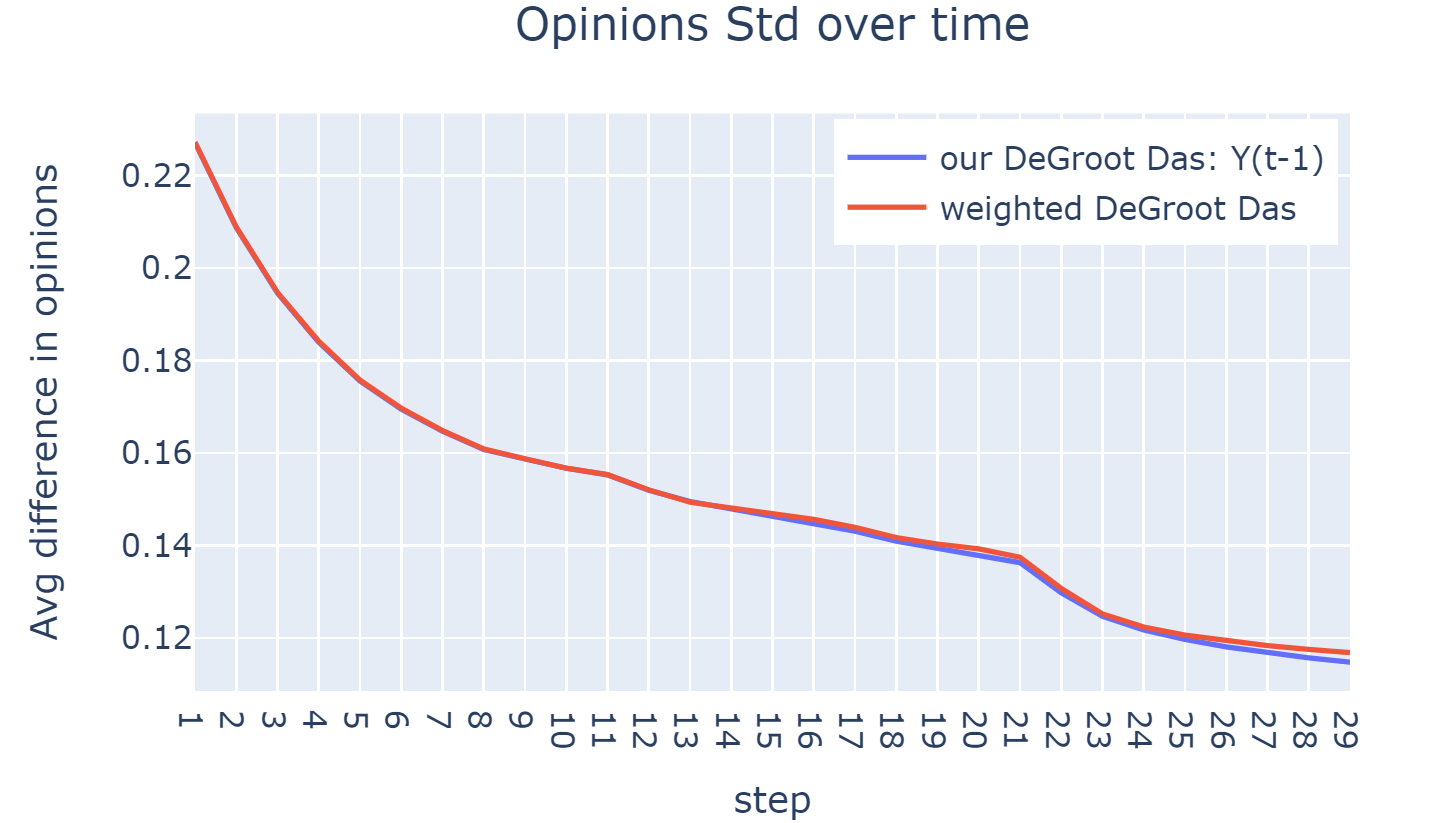

## 2. Incorporating Title Embeddings

Next, let's connect the network with real-world publication data. A paper is represented by the embeddings of its title, which are obtained from a language model specifically trained on SemanticScholar data (SciBERT, https://github.com/allenai/scibert).

The embeddings have been packed as a pickle file (data/History/scibert_embeddings.pkl). You can find it on Github. It's more than 1GB, so please secure your downloading and local environments before getting the file (server is recommended).

### Code Changes: Read the embeddings from the pickle file

Add the following to the beginning of the experiments script:

In [2]:
import pickle

with open('data/History/scibert_embeddings.pkl', 'rb') as f1:
    embedding_dict = pickle.load(f1)

_embedding_dict_ keeps paper IDs as keys, the corresponding embeddings of a paper as values (formatted as a list, and you may want to change it to np.array or tensors):

In [3]:
print(len(embedding_dict[2809278917]))
#print(embedding_dict[2809278917])

768


We'll access the vector representations from _embedding_dict_ based on paper IDs. We start by incorporating this into initialization.

### Replacing random opinion initialization with an author's first work

First, we will replace the random init in GraphAttributeClass with real-world data. How should we represent an author's "initial" opinion given a time span? 

One intuitive approach is: **use the first paper associated with them** as the representation. (We would need to consider both Citing_PaperID and Cited_PaPerID domains -- one can be cited but didn't publish anything from 2019 to 2020, or vice versa.)

### Code changes: class GraphAttributeClass
Under _GraphAttributeClass_, find the function _assign_node_attr_opinion_. Replace the original function with the new ones as follows:

In [2]:
class GraphAttributeClass:
    '''... (other code; no need to change) ...'''
    
    def assign_node_attr_opinion(self):
        """
        Initialize the opinion of an author with their first occurence (chronologically) in the citation dataset.
        By "occurence", it can refer to either a paper cited, or a paper citing others' work, that is the first piece of data for an author.
        """
        
        global embedding_dict
        
        for node in self.g.nodes:
            # extract the first piece of data containing the author's ID
            item_dict = df[(df.Citing_AuthorID == node) | (df.Cited_AuthorID == node)].iloc[0].to_dict()
            
            # (prioritize cited paper because one can cite themselves, and we should use the earlier paper (the one being cited).)
            if node == item_dict['Cited_AuthorID']: # the node's first occurence is being cited
                self.g.nodes[node]['opinion'] = embedding_dict[item_dict['Cited_PaperID']]
            else: # the node's first occurence is citing others' work
                self.g.nodes[node]['opinion'] = embedding_dict[item_dict['Citing_PaperID']]
                
            self.g.nodes[node]['conformity'] = np.random.uniform(0, 1)
            self.g.nodes[node]['node_centrality'] = 0.01 + self.g.degree(node)
    
    '''... (end of assign_node_attr_opinion) ...'''
    '''... (other code; no need to change) ...'''

*(N.B: if you are experimenting with other _conformity_ and _node_centrality_ initializations, change the last two lines of code above accordingly.)*

The code implements the above approach and finds the first line of data in _df_ that contains the node as author, and then links the node to the ID of the paper in that line.

## Checkpoint 2

Run again with the changes so far, and you would get:

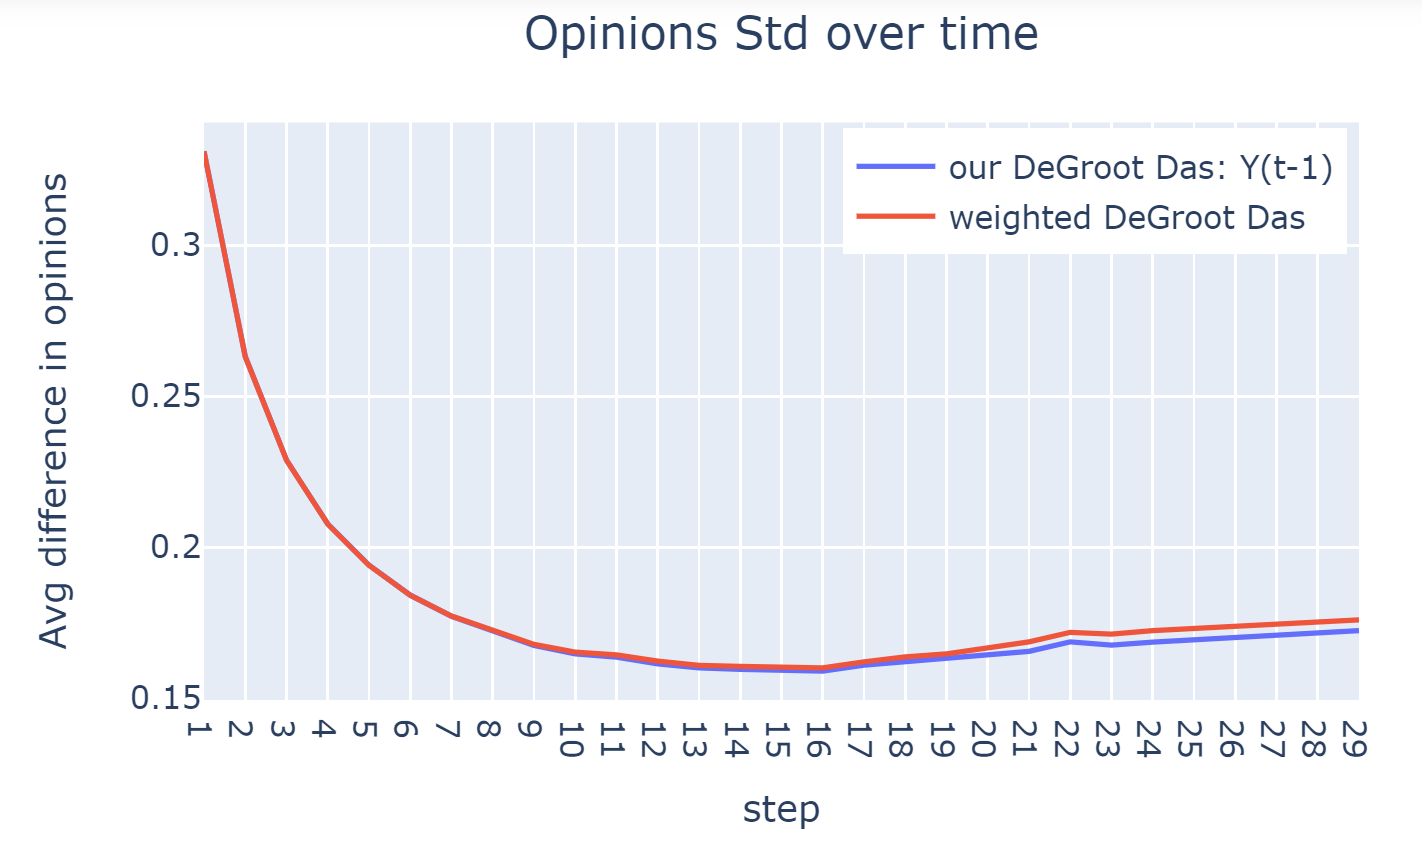

## 3. Update opinions when authors publish new papers

The final step is to update nodes' opinions when they appear in the new edges as citing authors, i.e., when they publish a new paper and thus appear in the dataset.

There are many choices of how to update the opinions. Here we choose a simple method of _gradient descent_: the change is in proportion to the difference of the original opinion Y and the new papers' representations Emb:

$$Y_{new} = Y + \delta (Emb - Y)$$

### Code Changes: class UpdateGraphClass

Under _UpdateGraphClass_, in _add_new_edges_per_time_step_:

after _# merge with original graph_ and before _# recalculate attrs_ (i.e., ~Line 41 of that block), add the following:

In [1]:
class UpdateGraphClass:
    ''' ... (other code; no need to change) ...'''
    
    def add_new_edges_per_time_step(self, g, mode: str='month') -> (list, str):
    
        '''
        ... (other code; no need to change) ...

        # merge with original graph
        graph_merged = nx.compose(adding_graph_with_attr, g)  # '''
        
        # update authors' opinions with their new publications
        delta_step = 0.2 # super-parameter controlling the speed of gradient update
        global embedding_dict
        author_paper_add_list = list(zip(df_add['Citing_AuthorID'], df_add['Citing_PaperID']))
        author_paper_add_list = pd.unique(author_paper_add_list)
        for author_id, paper_id in author_paper_add_list:
            graph_merged.nodes[author_id]['opinion'] += delta_step * (embedding_dict[paper_id] - graph_merged.nodes[author_id]['opinion'])
            
        '''
        # recalculate attrs
        graph_merged = super().add_recalculated_attrs(graph_merged)
        
        ...        

        ... (other code; no need to change) ...'''

That's it! Congrats and hope these are helpful.